# CSX46 - Class Session 7 - Closeness centrality

In this class session we are going to scatter-plot the harmonic-mean closeness centralities
of the vertices in the gene regulatory network (which we will obtain from Pathway Commons) with the vertices' degree centralities. We will get the geodesic path distances using `igraph`, which will use BFS for this graph.

We are going to use `pandas`, `igraph`, `numpy`, and `timeit`

In [1]:
import pandas
import igraph
import numpy
import timeit

Load in the SIF file for Pathway Commons, using `pandas.read_csv` and specifying the three column names `species1`, `interaction_type`, and `species2`:

In [2]:
sif_data = pandas.read_csv("shared/pathway_commons.sif",
                           sep="\t", names=["species1","interaction_type","species2"])

Subset the data frame to include only rows for which the `interaction_type` column contains the string `controls-expression-of`; subset columns to include only columns `species1` and `species2` using the `[` operator and the list `["species1","species2"]`; and eliminate redundant edges in the edge-list using the `drop_duplicates` method. 

In [3]:
interac_grn = sif_data[sif_data.interaction_type == "controls-expression-of"]
interac_grn_unique = interac_grn[["species1","species2"]].drop_duplicates()

Create a undirected graph in igraph, from the dataframe edge-list, using `Graph.TupleList` and specifying `directed=False`. Print out the graph summary using the `summary` instance method.

In [4]:
grn_igraph = igraph.Graph.TupleList(interac_grn_unique.values.tolist(), directed=False)
grn_igraph.summary()

'IGRAPH UN-- 14208 110013 -- \n+ attr: name (v)'

For one vertex at a time (iterating over the vertex sequence `grn_igraph.vs`), compute that vertex's harmonic mean closeness centrality using Eq. 7.30 from Newman's book. Don't forget to eliminate the "0" distance between a vertex and itself, in the results you get back from calling the `shortest_paths` method on the `Vertex` object.   Just for information purposes, measure how long the code takes to run, in seconds, using `timeit.default_timer()`. 

In [5]:
N = len(grn_igraph.vs)

# allocate a vector to contain the harmonic-mean vertex closeness centralities; initialize to zeroes
# (so if a vertex is a singleton we don't have to update its harmonic-mean closeness centrality)
hm_closeness_centralities = numpy.zeros(N)

# allocate a vector to contain the vertex closeness centralities; initialize to zeroes
# (so if a vertex is a singleton we don't have to update its closeness centrality)
closeness_centralities = numpy.zeros(N)

# initialize a counter
ctr = 0

# start the timer
start_time = timeit.default_timer()

# for each vertex in `grn_igraph.vs`
for my_vertex in grn_igraph.vs:
    
    # compute the geodesic distance to every other vertex, from my_vertex, using the `shortest_paths` instance method;
    # put it in a numpy.array
    my_dists = numpy.array(my_vertex.shortest_paths())
    
    # igraph computes CC by setting the "distance" to a vertex that is in a different component, to N
    my_dists[numpy.logical_not(numpy.isfinite(my_dists))] = N
    
    ## this equation is how you would compute CC according to Newman's Eq. 7.29:
    # my_dists = my_dists[numpy.isfinite(my_dists) & (my_dists > 0)]

    # filter the numpy array to include only entries that are positive 
    my_dists = my_dists[my_dists > 0]
    

    if len(my_dists) > 0:
        # compute harmonic-mean closeness centrality following Eq. 7.30 in Newman
        hm_closeness_centralities[ctr] = numpy.sum(1/my_dists)/(N-1)
        
        # NOTE: igraph uses "N-1" but Newman uses "N" in Eq. 7.29; we'll folow igraph here
        closeness_centralities[ctr] = (N-1)/numpy.sum(my_dists)
    ctr += 1
    
# compute the elapsed time
ci_elapsed = timeit.default_timer() - start_time
print("Elapsed time: %0.2f s" % ci_elapsed)

Elapsed time: 118.70 s


Now, let's compute the closeness centralities using igraph's method `igraph.Graph.closeness`. How long does it take to run?

In [6]:
start_time = timeit.default_timer()
cc_igraph = grn_igraph.closeness(normalized=True)
elapsed_time = timeit.default_timer() - start_time
print("Elapsed time: %0.2f s" % elapsed_time)

Elapsed time: 30.84 s


Compare `cc_igraph` with `closeness_centralities`; are they all the same?

In [7]:
len(numpy.where(numpy.abs(closeness_centralities-cc_igraph) != 0.)[0])

0

Histogram the harmonic-mean closeness centralities.  Do they have a large dynamic range?

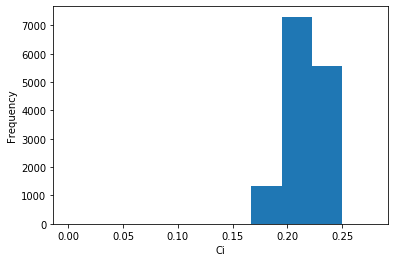

In [8]:
import matplotlib.pyplot
matplotlib.pyplot.hist(closeness_centralities)
matplotlib.pyplot.xlabel("Ci")
matplotlib.pyplot.ylabel("Frequency")
matplotlib.pyplot.show()

Scatter plot the harmonic-mean closeness centralities vs. the log10 degree. Is there any kind of relationship?

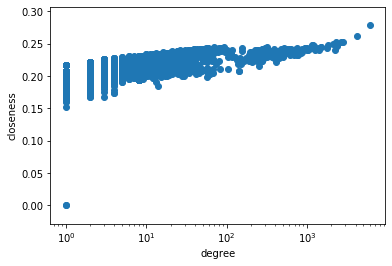

In [9]:
ax = matplotlib.pyplot.gca()
ax.scatter(grn_igraph.degree(), closeness_centralities)
ax.set_xscale("log")
matplotlib.pyplot.xlabel("degree")
matplotlib.pyplot.ylabel("closeness")
matplotlib.pyplot.show()

Which protein has the highest harmonic-mean closeness centrality in the network, and what is its centrality value? use `numpy.argmax`

In [10]:
print(numpy.max(closeness_centralities))
grn_igraph.vs[numpy.argmax(closeness_centralities)]["name"]

0.2781268964977193


'CYP26A1'

Print names of the top 10 proteins in the network, by harmonic-mean closeness centrality:, using `numpy.argsort`:

In [11]:
grn_igraph.vs[numpy.argsort(closeness_centralities)[::-1][0:9].tolist()]["name"]

['CYP26A1', 'TCF3', 'LEF1', 'MAZ', 'MYC', 'FOXO4', 'PAX4', 'PITX2', 'HNF1A']

Let's do it using a Pandas `DataFrame`:

In [12]:
cc_df = pandas.DataFrame(list(zip(grn_igraph.vs["name"], 
                                  closeness_centralities.tolist())),
                        columns=["protein","CC"])
cc_df = cc_df.set_index("protein")
cc_df.sort_values("CC", ascending=False).head(n=10)

,CC
protein,
CYP26A1,0.278127
TCF3,0.261105
LEF1,0.253163
MAZ,0.253037
MYC,0.251799
FOXO4,0.249877
PAX4,0.247906
PITX2,0.247768
HNF1A,0.247100
